<a href="https://colab.research.google.com/github/ywyue/FiT3D/blob/main/FiT3D_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo for **Improving 2D Feature Representations by 3D-Aware Fine-Tuning**
### ECCV 2024
Yuanwen Yue, Anurag Das, Francis Engelmann, Siyu Tang, Jan Eric Lenssen

**ETH Zurich,
Max Planck Institute for Informatics,
Google**

* Project page: https://ywyue.github.io/FiT3D/
* Github: https://github.com/ywyue/FiT3D
* Paper: https://arxiv.org/abs/2407.20229
* Hugging Face demo: https://huggingface.co/spaces/yuanwenyue/FiT3D





Please choose **Python3** as Runtime type and **T4 GPU** as Hardware accelerator. The demo also works with CPU.


In [1]:
### install timm and torch_kmeans as they are not included in the default python environment
!pip install timm==0.9.10
!pip install torch_kmeans

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 3.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

## Preparation (load packages and define necessary functions)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
import timm
import torch
import types
import albumentations as A

from PIL import Image
from sklearn.decomposition import PCA
from torch_kmeans import KMeans, CosineSimilarity


cmap = plt.get_cmap("tab20")
MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255

transforms = A.Compose([
            A.Normalize(mean=list(MEAN), std=list(STD)),
    ])


def get_intermediate_layers(
    self,
    x: torch.Tensor,
    n=1,
    reshape: bool = False,
    return_prefix_tokens: bool = False,
    return_class_token: bool = False,
    norm: bool = True,
):
    outputs = self._intermediate_layers(x, n)
    if norm:
        outputs = [self.norm(out) for out in outputs]
    if return_class_token:
        prefix_tokens = [out[:, 0] for out in outputs]
    else:
        prefix_tokens = [out[:, 0 : self.num_prefix_tokens] for out in outputs]
    outputs = [out[:, self.num_prefix_tokens :] for out in outputs]

    if reshape:
        B, C, H, W = x.shape
        grid_size = (
            (H - self.patch_embed.patch_size[0])
            // self.patch_embed.proj.stride[0]
            + 1,
            (W - self.patch_embed.patch_size[1])
            // self.patch_embed.proj.stride[1]
            + 1,
        )
        outputs = [
            out.reshape(x.shape[0], grid_size[0], grid_size[1], -1)
            .permute(0, 3, 1, 2)
            .contiguous()
            for out in outputs
        ]

    if return_prefix_tokens or return_class_token:
        return tuple(zip(outputs, prefix_tokens))
    return tuple(outputs)


def viz_feat(feat):

    _, _, h, w = feat.shape
    feat = feat.squeeze(0).permute((1,2,0))
    projected_featmap = feat.reshape(-1, feat.shape[-1]).cpu()

    pca = PCA(n_components=3)
    pca.fit(projected_featmap)
    pca_features = pca.transform(projected_featmap)
    pca_features = (pca_features - pca_features.min()) / (pca_features.max() - pca_features.min())
    pca_features = pca_features * 255
    res_pred = Image.fromarray(pca_features.reshape(h, w, 3).astype(np.uint8))

    return res_pred


def plot_feats(image, model_option, ori_feats, fine_feats, ori_labels=None, fine_labels=None):

    ori_feats_map = viz_feat(ori_feats)
    fine_feats_map = viz_feat(fine_feats)

    if ori_labels is not None:
        fig, ax = plt.subplots(2, 3, figsize=(10, 5))
        ax[0][0].imshow(image)
        ax[0][0].set_title("Input image", fontsize=15)
        ax[0][1].imshow(ori_feats_map)
        ax[0][1].set_title("Original " + model_option, fontsize=15)
        ax[0][2].imshow(fine_feats_map)
        ax[0][2].set_title("Ours", fontsize=15)
        ax[1][1].imshow(ori_labels)
        ax[1][2].imshow(fine_labels)
        for xx in ax:
          for x in xx:
            x.xaxis.set_major_formatter(plt.NullFormatter())
            x.yaxis.set_major_formatter(plt.NullFormatter())
            x.set_xticks([])
            x.set_yticks([])
            x.axis('off')

    else:
        fig, ax = plt.subplots(1, 3, figsize=(10, 10))
        ax[0].imshow(image)
        ax[0].set_title("Input image", fontsize=15)
        ax[1].imshow(ori_feats_map)
        ax[1].set_title("Original " + model_option, fontsize=15)
        ax[2].imshow(fine_feats_map)
        ax[2].set_title("Ours", fontsize=15)

        for x in ax:
          x.xaxis.set_major_formatter(plt.NullFormatter())
          x.yaxis.set_major_formatter(plt.NullFormatter())
          x.set_xticks([])
          x.set_yticks([])
          x.axis('off')

    plt.tight_layout()
    plt.close(fig)
    return fig


def download_image(url, save_path):
    response = requests.get(url)
    with open(save_path, 'wb') as file:
        file.write(response.content)


def process_image(image, stride, transforms):
    transformed = transforms(image=np.array(image))
    image_tensor = torch.tensor(transformed['image'])
    image_tensor = image_tensor.permute(2,0,1)
    image_tensor = image_tensor.unsqueeze(0).to(device)

    h, w = image_tensor.shape[2:]

    height_int = (h // stride)*stride
    width_int = (w // stride)*stride

    image_resized = torch.nn.functional.interpolate(image_tensor, size=(height_int, width_int), mode='bilinear')

    return image_resized


def kmeans_clustering(feats_map, n_clusters=20):

    B, D, h, w = feats_map.shape
    feats_map_flattened = feats_map.permute((0, 2, 3, 1)).reshape(B, -1, D)

    kmeans_engine = KMeans(n_clusters=n_clusters, distance=CosineSimilarity)
    kmeans_engine.fit(feats_map_flattened)
    labels = kmeans_engine.predict(
        feats_map_flattened
        )
    labels = labels.reshape(
        B, h, w
        ).float()
    labels = labels[0].cpu().numpy()

    label_map = cmap(labels / n_clusters)[..., :3]
    label_map = np.uint8(label_map * 255)
    label_map = Image.fromarray(label_map)

    return label_map


def run_demo(model_option, image_path, kmeans=20):
    """
    Run the demo for a given model option and image
    model_option: ['DINOv2', 'DINOv2-reg', 'CLIP', 'MAE', 'DeiT-III']
    image_path: path to the image
    kmeans: number of clusters for kmeans. Default is 20. -1 means no kmeans.
    """
    original_model = original_models[model_option]
    fine_model = fine_models[model_option]
    p = original_model.patch_embed.patch_size
    stride = p if isinstance(p, int) else p[0]
    image = Image.open(image_path)
    image_resized = process_image(image, stride, transforms)
    with torch.no_grad():
        ori_feats = original_model.get_intermediate_layers(image_resized, n=[8,9,10,11], reshape=True, return_prefix_tokens=False,
                                    return_class_token=False, norm=True)
        fine_feats = fine_model.get_intermediate_layers(image_resized, n=[8,9,10,11], reshape=True, return_prefix_tokens=False,
                                    return_class_token=False, norm=True)

    ori_feats = ori_feats[-1]
    fine_feats = fine_feats[-1]

    if kmeans != -1:
        ori_labels = kmeans_clustering(ori_feats, kmeans)
        fine_labels = kmeans_clustering(fine_feats, kmeans)
    else:
        ori_labels = None
        fine_labels = None


    return plot_feats(image, model_option, ori_feats, fine_feats, ori_labels, fine_labels)

## Download sample images

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print("device: ")
print(device)

example_dir = "/tmp/examples"
os.makedirs(example_dir, exist_ok=True)


example_urls = {
    "library.jpg": "https://n.ethz.ch/~yuayue/assets/fit3d/demo_images/library.jpg",
    "livingroom.jpg": "https://n.ethz.ch/~yuayue/assets/fit3d/demo_images/livingroom.jpg",
    "airplane.jpg": "https://n.ethz.ch/~yuayue/assets/fit3d/demo_images/airplane.jpg",
    "ship.jpg": "https://n.ethz.ch/~yuayue/assets/fit3d/demo_images/ship.jpg",
    "chair.jpg": "https://n.ethz.ch/~yuayue/assets/fit3d/demo_images/chair.jpg",
}

example_dir = "/tmp/examples"

os.makedirs(example_dir, exist_ok=True)


for name, url in example_urls.items():
    save_path = os.path.join(example_dir, name)
    if not os.path.exists(save_path):
        print(f"Downloading to {save_path}...")
        download_image(url, save_path)
    else:
        print(f"{save_path} already exists.")

device: 
cuda


## Download models

In [4]:
options = ['DINOv2', 'DINOv2-reg', 'CLIP', 'MAE', 'DeiT-III']

timm_model_card = {
    "DINOv2": "vit_small_patch14_dinov2.lvd142m", # default is small, for base change to "vit_base_patch14_dinov2.lvd142m"
    "DINOv2-reg": "vit_small_patch14_reg4_dinov2.lvd142m",
    "CLIP": "vit_base_patch16_clip_384.laion2b_ft_in12k_in1k",
    "MAE": "vit_base_patch16_224.mae",
    "DeiT-III": "deit3_base_patch16_224.fb_in1k"
}

our_model_card = {
    "DINOv2": "dinov2_small_fine", # default is small, for base change to "dinov2_base_fine"
    "DINOv2-reg": "dinov2_reg_small_fine",
    "CLIP": "clip_base_fine",
    "MAE": "mae_base_fine",
    "DeiT-III": "deit3_base_fine"
}

os.environ['TORCH_HOME'] = '/tmp/.cache'

# Pre-load all models
original_models = {}
fine_models = {}
for option in options:
    original_models[option] = timm.create_model(
            timm_model_card[option],
            pretrained=True,
            num_classes=0,
            dynamic_img_size=True,
            dynamic_img_pad=False,
        ).to(device)
    original_models[option].get_intermediate_layers = types.MethodType(
        get_intermediate_layers,
        original_models[option]
    )

    fine_models[option] = torch.hub.load("ywyue/FiT3D", our_model_card[option]).to(device)
    fine_models[option].get_intermediate_layers = types.MethodType(
        get_intermediate_layers,
        fine_models[option]
    )


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/hub.py:293: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ywyue/FiT3D/zipball/main" to /tmp/.cache/hub/main.zip
Downloading: "https://huggingface.co/yuanwenyue/FiT3D/resolve/main/dinov2_small_finetuned.pth" to /tmp/.cache/hub/checkpoints/dinov2_small_finetuned.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 202MB/s]


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Using cache found in /tmp/.cache/hub/ywyue_FiT3D_main
Downloading: "https://huggingface.co/yuanwenyue/FiT3D/resolve/main/dinov2_reg_small_finetuned.pth" to /tmp/.cache/hub/checkpoints/dinov2_reg_small_finetuned.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 286MB/s]


model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

Using cache found in /tmp/.cache/hub/ywyue_FiT3D_main
Downloading: "https://huggingface.co/yuanwenyue/FiT3D/resolve/main/clip_base_finetuned.pth" to /tmp/.cache/hub/checkpoints/clip_base_finetuned.pth
100%|██████████| 328M/328M [00:02<00:00, 167MB/s]


model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

Using cache found in /tmp/.cache/hub/ywyue_FiT3D_main
Downloading: "https://huggingface.co/yuanwenyue/FiT3D/resolve/main/mae_base_finetuned.pth" to /tmp/.cache/hub/checkpoints/mae_base_finetuned.pth
100%|██████████| 327M/327M [00:01<00:00, 317MB/s]


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Using cache found in /tmp/.cache/hub/ywyue_FiT3D_main
Downloading: "https://huggingface.co/yuanwenyue/FiT3D/resolve/main/deit3_base_finetuned.pth" to /tmp/.cache/hub/checkpoints/deit3_base_finetuned.pth
100%|██████████| 327M/327M [00:01<00:00, 174MB/s]


## Demo with DINOv2

/usr/local/lib/python3.10/dist-packages/torch_kmeans/clustering/kmeans.py:530: UserWarning: standard k-means should use a non-inverted distance measure.
  warn("standard k-means should use a non-inverted distance measure.")


Full batch converged at iteration 80/100 with center shifts = tensor([0.], device='cuda:0').
Full batch converged at iteration 43/100 with center shifts = tensor([0.], device='cuda:0').


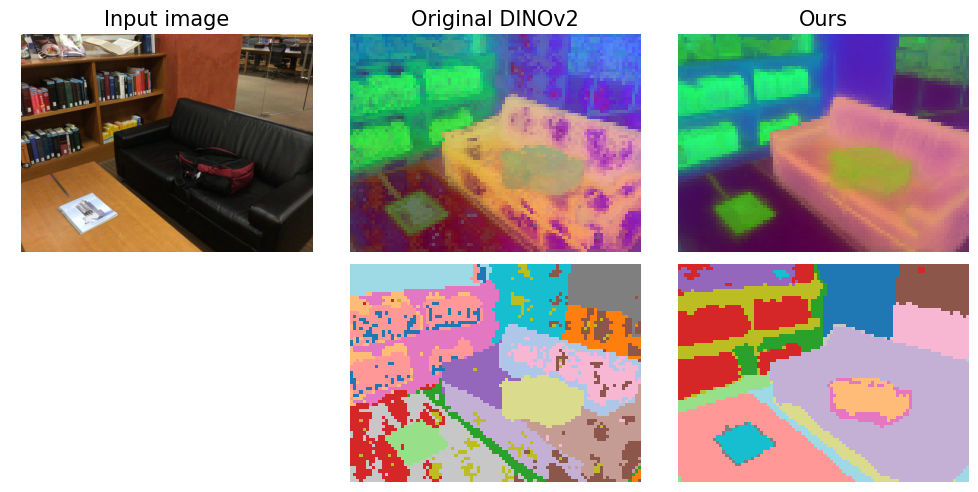

In [5]:
model_option = "DINOv2"
image_path = os.path.join(example_dir, "library.jpg")
kmeans = 20
run_demo(model_option, image_path, kmeans)

## Demo with DINOv2-reg

/usr/local/lib/python3.10/dist-packages/torch_kmeans/clustering/kmeans.py:530: UserWarning: standard k-means should use a non-inverted distance measure.
  warn("standard k-means should use a non-inverted distance measure.")


Full batch converged at iteration 35/100 with center shifts = tensor([0.], device='cuda:0').
Full batch converged at iteration 39/100 with center shifts = tensor([0.], device='cuda:0').


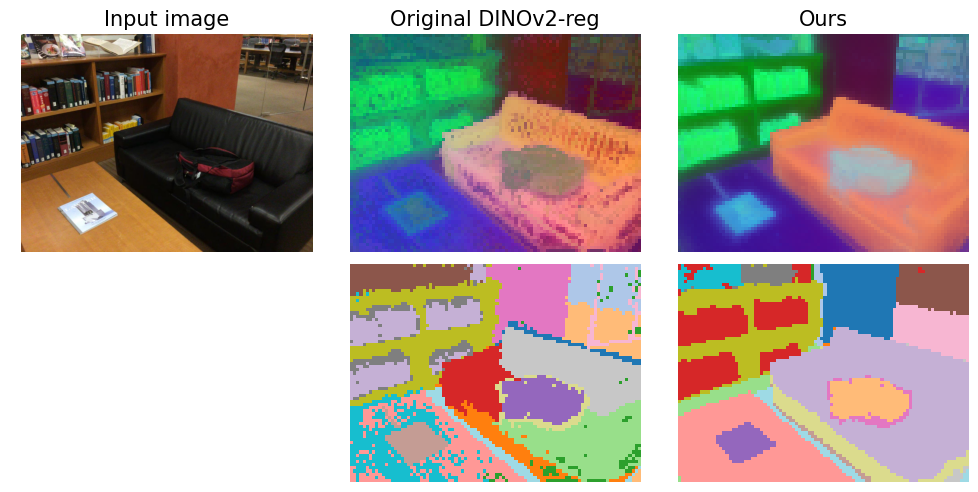

In [6]:
model_option = "DINOv2-reg"
image_path = os.path.join(example_dir, "library.jpg")
kmeans = 20
run_demo(model_option, image_path, kmeans)

## Demo with CLIP

/usr/local/lib/python3.10/dist-packages/torch_kmeans/clustering/kmeans.py:530: UserWarning: standard k-means should use a non-inverted distance measure.
  warn("standard k-means should use a non-inverted distance measure.")


Full batch converged at iteration 35/100 with center shifts = tensor([0.], device='cuda:0').


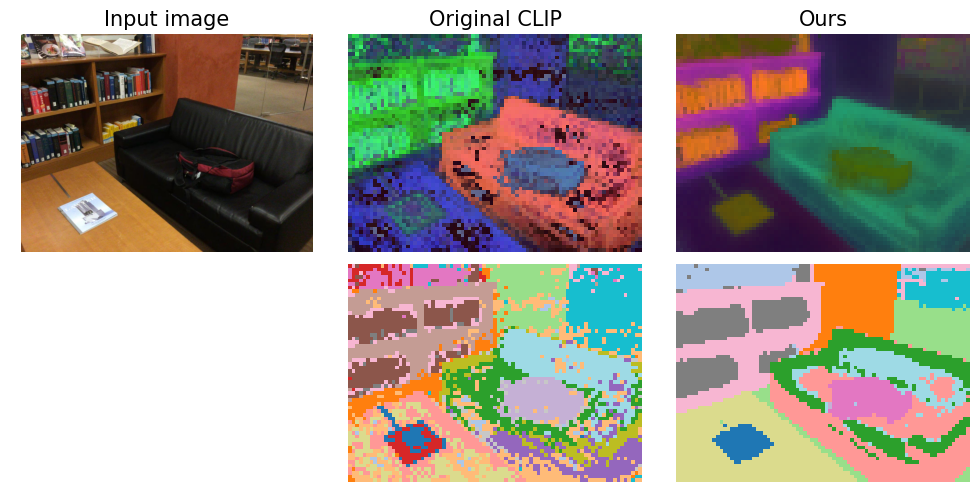

In [7]:
model_option = "CLIP"
image_path = os.path.join(example_dir, "library.jpg")
kmeans = 20
run_demo(model_option, image_path, kmeans)

## Demo with MAE

/usr/local/lib/python3.10/dist-packages/torch_kmeans/clustering/kmeans.py:530: UserWarning: standard k-means should use a non-inverted distance measure.
  warn("standard k-means should use a non-inverted distance measure.")


Full batch converged at iteration 27/100 with center shifts = tensor([0.], device='cuda:0').


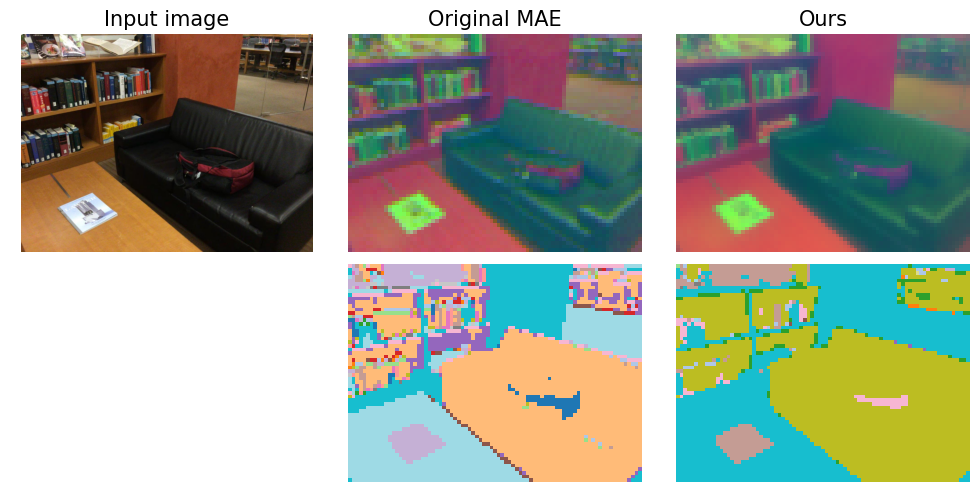

In [8]:
model_option = "MAE"
image_path = os.path.join(example_dir, "library.jpg")
kmeans = 20
run_demo(model_option, image_path, kmeans)

## Demo with DeiT-III

/usr/local/lib/python3.10/dist-packages/torch_kmeans/clustering/kmeans.py:530: UserWarning: standard k-means should use a non-inverted distance measure.
  warn("standard k-means should use a non-inverted distance measure.")


Full batch converged at iteration 62/100 with center shifts = tensor([0.], device='cuda:0').


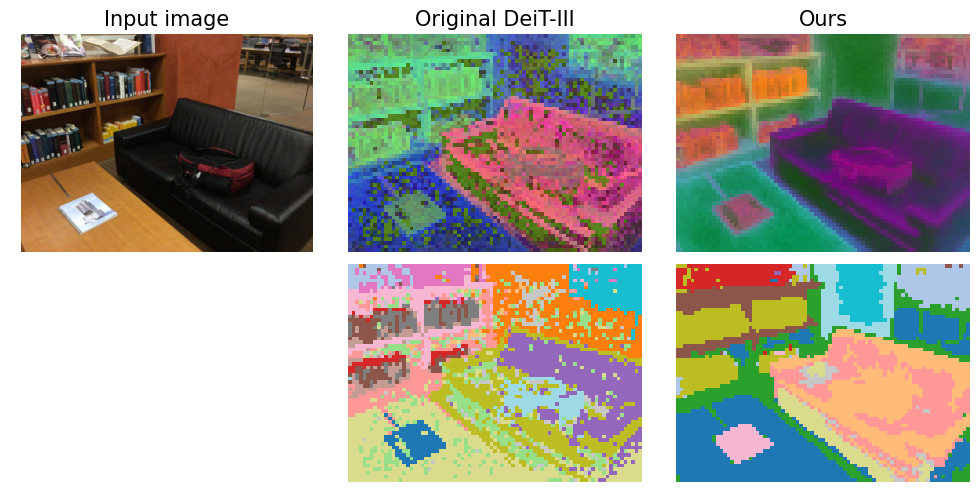

In [9]:
model_option = "DeiT-III"
image_path = os.path.join(example_dir, "library.jpg")
kmeans = 20
run_demo(model_option, image_path, kmeans)